Importing the necessaries

In [282]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
import torch

Loading the dataset from disk

In [283]:
train_dataset = load_dataset('rootblind/opjustice-dataset', split='train')
test_dataset = load_dataset('rootblind/opjustice-dataset', split='test')

Inspecting data

In [284]:
train_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,cred,1,0,0,0,0
1,aia zic,1,0,0,0,0
2,Gg slowmode enable,1,0,0,0,0
3,Sa se ia msuri,1,0,0,0,0
4,de ce credeti ca e editat mesaju,1,0,0,0,0


In [285]:
test_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,Unde,1,0,0,0,0
1,un baiat cioci,1,0,0,0,0
2,Nu are voie,1,0,0,0,0
3,eu merg cu trenul cand nu ploua,1,0,0,0,0
4,mia aratat nudes in privat cum a promis,1,0,0,0,0


Converting the dataset to pandas for easier analysis

In [286]:
import pandas as pd

df_train = train_dataset.to_pandas()
df_test = test_dataset.to_pandas()

df_train.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,6083.000000,6083.000000,6083.000000,6083.000000,6083.000000
mean,0.875226,0.072497,0.019398,0.053921,0.018905
std,0.330490,0.281230,0.137932,0.225880,0.136201
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,9.000000,1.000000,1.000000,1.000000


In [287]:
df_test.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,1518.000000,1518.000000,1518.000000,1518.000000,1518.000000
mean,0.876153,0.071146,0.014493,0.054677,0.018445
std,0.329516,0.257154,0.119550,0.227424,0.134600
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [288]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6083 entries, 0 to 6082
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   6083 non-null   object
 1   OK        6083 non-null   int64 
 2   Aggro     6083 non-null   int64 
 3   Violence  6083 non-null   int64 
 4   Sexual    6083 non-null   int64 
 5   Hateful   6083 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 285.3+ KB


In [289]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518 entries, 0 to 1517
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   1518 non-null   object
 1   OK        1518 non-null   int64 
 2   Aggro     1518 non-null   int64 
 3   Violence  1518 non-null   int64 
 4   Sexual    1518 non-null   int64 
 5   Hateful   1518 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 71.3+ KB


In [290]:
df_train.isnull().sum()

Message     0
OK          0
Aggro       0
Violence    0
Sexual      0
Hateful     0
dtype: int64

In [291]:
print('Train shape: ', str(df_train.shape))
print('Test shape: ', str(df_test.shape))

Train shape:  (6083, 6)
Test shape:  (1518, 6)


In [292]:
print(f'Number of duplicated instances in train: {df_train.duplicated().sum()}')
print(f'Number of duplicated instances in test: {df_test.duplicated().sum()}')

Number of duplicated instances in train: 137
Number of duplicated instances in test: 8


In [293]:
numeric_df = df_train.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                OK     Aggro  Violence    Sexual   Hateful
OK        1.000000 -0.666877 -0.372507 -0.632284 -0.367648
Aggro    -0.666877  1.000000  0.213820  0.267166  0.118743
Violence -0.372507  0.213820  1.000000  0.035027  0.067996
Sexual   -0.632284  0.267166  0.035027  1.000000  0.036337
Hateful  -0.367648  0.118743  0.067996  0.036337  1.000000


Data visualization

In [294]:
import matplotlib.pyplot as plt # importing the neccessary library

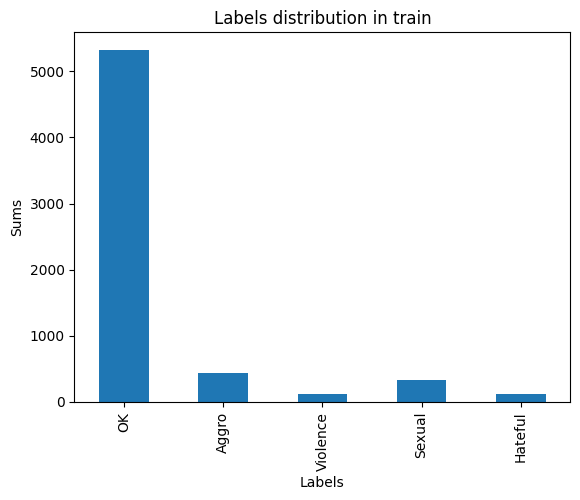

OK          5324
Aggro        441
Violence     118
Sexual       328
Hateful      115
dtype: int64


In [295]:
columns = df_train.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in train')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

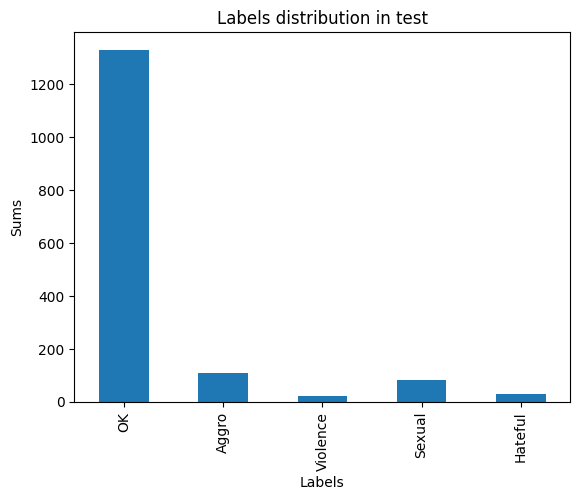

OK          1330
Aggro        108
Violence      22
Sexual        83
Hateful       28
dtype: int64


In [296]:
columns = df_test.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in test')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

<Axes: >

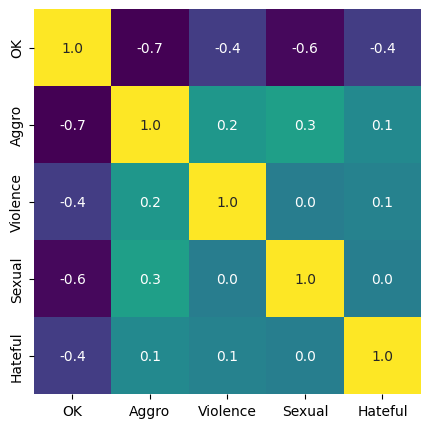

In [297]:
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cbar=None,cmap='viridis')

Comparing the train and the test datasets sizes

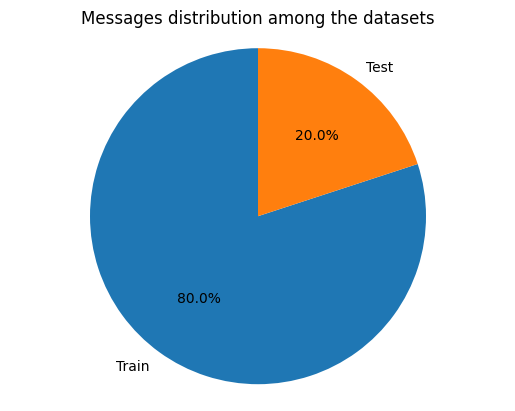

[6083, 1518]


In [298]:
train_test = ['Train', 'Test']
train_test_size = [df_train['Message'].value_counts().sum(), df_test['Message'].value_counts().sum()]
plt.pie(train_test_size, labels=train_test, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Messages distribution among the datasets')
plt.show()
print(train_test_size)

## Model evaluation

In [299]:
accuracy_array = []
models_used = ['My model']

### My model

In [300]:
class ToxicityDataset:
    def __init__(self, dataset_path='./automod-model/dataset', dataset_name='rootblind/opjustice-dataset'):
        self.dataset_path = dataset_path
        self.dataset_name = dataset_name
        self.dataset = self.load_dataset()
        self.labels = self.get_labels()
        self.id2label, self.label2id = self.create_label_mappings()

    def load_dataset(self):
        dataset = load_dataset(self.dataset_name)
        return dataset

    def get_labels(self):
        return [label for label in self.dataset['train'].features.keys() if label not in 'Message']

    def create_label_mappings(self):
        id2label = {idx: label for idx, label in enumerate(self.labels)}
        label2id = {label: idx for idx, label in enumerate(self.labels)}
        return id2label, label2id

    def preprocess_data(self, examples, tokenizer):
        text = examples["Message"]
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=400)
        labels_batch = {k: examples[k] for k in examples.keys() if k in self.labels}
        labels_matrix = np.zeros((len(text), len(self.labels)))

        for idx, label in enumerate(self.labels):
            labels_matrix[:, idx] = labels_batch[label]

        encoding["labels"] = labels_matrix.tolist()
        return encoding

    def encode_dataset(self, tokenizer):
        encoded_dataset = self.dataset.map(lambda x: self.preprocess_data(x, tokenizer), batched=True, remove_columns=self.dataset['train'].column_names)
        encoded_dataset.set_format("torch")
        return encoded_dataset

In [301]:
class ToxicityModel:
    def __init__(self, model_name, num_labels, id2label, label2id, device=None):
        self.model_name = model_name
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(num_labels, id2label, label2id)

    def load_model(self, num_labels, id2label, label2id):
        model = AutoModelForSequenceClassification.from_pretrained(self.model_name, 
                                                                   problem_type="multi_label_classification", 
                                                                   num_labels=num_labels,
                                                                   id2label=id2label,
                                                                   label2id=label2id).to(self.device)
        
        return model

    def predict(self, text, tokenizer):
        encoding = tokenizer(text, return_tensors="pt")
        encoding = {k: v.to(self.device) for k, v in encoding.items()}
        with torch.no_grad():
            outputs = self.model(**encoding)
        
        logits = outputs.logits
        softmax = torch.nn.Softmax()
        probs = softmax(logits.squeeze().cpu())
        predictions = np.zeros(probs.shape)
        predictions[np.argmax(probs)] = 1
        return predictions

In [302]:
toxicityDataset = ToxicityDataset()
toxicityModel = ToxicityModel(
    model_name='./model_versions/automod-model-training-10',
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )

In [303]:
tokenizer = AutoTokenizer.from_pretrained('./model_versions/automod-model-training-10')
loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(tokenizer)

Map: 100%|██████████| 1518/1518 [00:00<00:00, 6272.68 examples/s]


In [304]:
X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]

In [305]:
y_pred = [toxicityModel.predict(text, tokenizer) for text in X_test]

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [306]:
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.8614973249204197
Precision: 0.8586173759678387
Recall: 0.875875238701464
Accuracy: 0.886034255599473
ROC AUC: 0.6165320160500356


c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [307]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[  83,  105],
        [  23, 1307]],

       [[1388,   22],
        [  85,   23]],

       [[1496,    0],
        [  22,    0]],

       [[1420,   15],
        [  37,   46]],

       [[1490,    0],
        [  28,    0]]], dtype=int64)

### Other algorithms

In [308]:
# calling the vectorizer to encode the announcements
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['Message'])
y_train = df_train.drop(columns='Message')
print(X_train.shape)

(6083, 7011)


In [309]:
X_test = vectorizer.transform(df_test['Message'])
y_test = df_test.drop(columns='Message')

X_test.shape

(1518, 7011)

In [310]:
model = MultiOutputClassifier(RandomForestClassifier())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [311]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('Random Forest')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1330
           1       0.71      0.25      0.37       108
           2       1.00      0.14      0.24        22
           3       0.84      0.43      0.57        83
           4       1.00      0.36      0.53        28

   micro avg       0.91      0.88      0.90      1571
   macro avg       0.89      0.43      0.53      1571
weighted avg       0.90      0.88      0.87      1571
 samples avg       0.91      0.90      0.90      1571



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [312]:
model = MultiOutputClassifier(GaussianNB())
model.fit(X_train.toarray(), y_train)

MultiOutputClassifier(estimator=GaussianNB())

In [313]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('GaussianNB')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.92      0.59      0.72      1330
           1       0.10      0.52      0.17       108
           2       0.02      0.27      0.05        22
           3       0.13      0.60      0.21        83
           4       0.06      0.54      0.10        28

   micro avg       0.39      0.58      0.47      1571
   macro avg       0.25      0.50      0.25      1571
weighted avg       0.80      0.58      0.63      1571
 samples avg       0.57      0.58      0.57      1571



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [314]:
model = MultiOutputClassifier(DecisionTreeClassifier())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier())

In [315]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('Decision Tree')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1330
           1       0.44      0.37      0.40       108
           2       0.36      0.23      0.28        22
           3       0.72      0.60      0.66        83
           4       0.74      0.50      0.60        28

   micro avg       0.88      0.88      0.88      1571
   macro avg       0.64      0.53      0.57      1571
weighted avg       0.87      0.88      0.87      1571
 samples avg       0.88      0.89      0.88      1571



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [316]:
model = MultiOutputClassifier(LogisticRegression())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression())

In [317]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('Logistic Regression')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1330
           1       0.78      0.19      0.31       108
           2       0.00      0.00      0.00        22
           3       0.73      0.19      0.30        83
           4       0.00      0.00      0.00        28

   micro avg       0.89      0.86      0.88      1571
   macro avg       0.48      0.28      0.31      1571
weighted avg       0.85      0.86      0.84      1571
 samples avg       0.89      0.88      0.89      1571



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Comparing accuracy between algorithms

<BarContainer object of 5 artists>

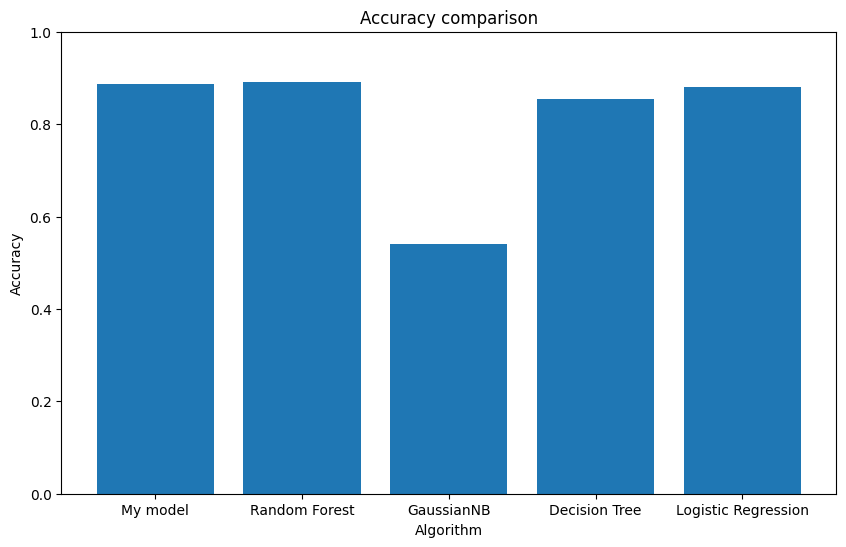

In [318]:
plt.figure(figsize=(10,6))
plt.title('Accuracy comparison')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.bar(models_used, accuracy_array)